# Real Estate Investment Profitability Calculator

This comprehensive tool evaluates the financial profitability of real estate investments using machine learning models trained on actual housing market data.

## 1. Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans

plt.style.use("default")
sns.set_palette("coolwarm")

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Data Loading and Preprocessing

In [3]:
def load_housing_data(csv_filename):
    df = pd.read_csv(csv_filename)
    
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    
    numeric_fields = ["price", "bedrooms", "bathrooms", "sqft_living", "sqft_lot", 
                     "floors", "waterfront", "view", "condition", "sqft_above", 
                     "sqft_basement", "yr_built", "yr_renovated"]
    
    for field in numeric_fields:
        if field in df.columns:
            df[field] = pd.to_numeric(df[field], errors="coerce")
    
    if "statezip" in df.columns:
        df["state"] = df["statezip"].str.extract(r"([A-Z]{2})")
        df["zipcode"] = df["statezip"].str.extract(r"(\d{5})")
    
    df = df.dropna(subset=["price", "sqft_living"])
    
    df["price_per_sqft"] = df["price"] / df["sqft_living"]
    current_year = datetime.now().year
    df["property_age"] = current_year - df["yr_built"]
    df["years_since_renovation"] = np.where(df["yr_renovated"] > 0, 
                                           current_year - df["yr_renovated"], 
                                           df["property_age"])
    df["total_sqft"] = df["sqft_living"] + df["sqft_basement"]
    df["lot_ratio"] = df["sqft_living"] / df["sqft_lot"]
    df["has_basement"] = (df["sqft_basement"] > 0).astype(int)
    df["is_renovated"] = (df["yr_renovated"] > 0).astype(int)
    
    print(f"Dataset loaded successfully: {len(df)} properties")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"Price range: ${df['price'].min():,.0f} - ${df['price'].max():,.0f}")
    print(f"Cities covered: {df['city'].nunique()}")
    print(f"Features engineered for ML: price_per_sqft, property_age, total_sqft, lot_ratio")
    
    return df

## 3. Loading Dataset

In [4]:
df = load_housing_data("USA Housing Dataset.csv")
print(df.info())
df.head()

Dataset loaded successfully: 4140 properties
Date range: 2014-05-02 00:00:00 to 2014-07-10 00:00:00
Price range: $0 - $26,590,000
Cities covered: 43
Features engineered for ML: price_per_sqft, property_age, total_sqft, lot_ratio
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4140 entries, 0 to 4139
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    4140 non-null   datetime64[ns]
 1   price                   4140 non-null   float64       
 2   bedrooms                4140 non-null   float64       
 3   bathrooms               4140 non-null   float64       
 4   sqft_living             4140 non-null   int64         
 5   sqft_lot                4140 non-null   int64         
 6   floors                  4140 non-null   float64       
 7   waterfront              4140 non-null   int64         
 8   view                    4140 non-null   int64         
 9  

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,country,state,zipcode,price_per_sqft,property_age,years_since_renovation,total_sqft,lot_ratio,has_basement,is_renovated
0,2014-05-09,376000.0,3.0,2.00,1340,1384,3.0,0,0,3,...,USA,WA,98103,280.597015,17,17,1340,0.968208,0,0
1,2014-05-09,800000.0,4.0,3.25,3540,159430,2.0,0,0,3,...,USA,WA,98014,225.988701,18,18,3540,0.022204,0,0
2,2014-05-09,2238888.0,5.0,6.50,7270,130017,2.0,0,0,3,...,USA,WA,98029,307.962586,15,15,8120,0.055916,1,0
3,2014-05-09,324000.0,3.0,2.25,998,904,2.0,0,0,3,...,USA,WA,98117,324.649299,18,18,1198,1.103982,1,0
4,2014-05-10,549900.0,5.0,2.75,3060,7015,1.0,0,0,5,...,USA,WA,98146,179.705882,46,46,4520,0.436208,1,0


## 4. ML Model Development

In [5]:
def prepare_ml_features(df):
    print("Preparing features for machine learning models...")
    
    feature_columns = ["bedrooms", "bathrooms", "sqft_living", "sqft_lot", "floors", 
                      "waterfront", "view", "condition", "sqft_above", "sqft_basement",
                      "property_age", "years_since_renovation", "total_sqft", "lot_ratio",
                      "has_basement", "is_renovated"]
    
    X = df[feature_columns].copy()
    
    le = LabelEncoder()
    df["city_encoded"] = le.fit_transform(df["city"])
    X["city_encoded"] = df["city_encoded"]
    
    y = df["price"]
    
    X = X.fillna(X.median())
    
    print(f"Features prepared: {X.shape[1]} features, {X.shape[0]} samples")
    print(f"Feature columns: {list(X.columns)}")
    
    return X, y, le

def train_ml_models(X, y):
    print("Training multiple ML models...")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    models = {
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
        "Linear Regression": LinearRegression()
    }
    
    model_results = {}
    scaler = StandardScaler()
    
    for name, model in models.items():
        print(f"Training {name}...")
        
        if name == "Linear Regression":
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            model.fit(X_train_scaled, y_train)
            predictions = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
        
        mae = mean_absolute_error(y_test, predictions)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        r2 = r2_score(y_test, predictions)
        
        model_results[name] = {
            "model": model,
            "mae": mae,
            "rmse": rmse,
            "r2": r2,
            "predictions": predictions
        }
        
        print(f"{name} - MAE: ${mae:,.0f}, RMSE: ${rmse:,.0f}, R²: {r2:.3f}")
    
    return model_results, X_test, y_test, scaler

X, y, label_encoder = prepare_ml_features(df)
model_results, X_test, y_test, scaler = train_ml_models(X, y)

best_model_name = min(model_results.keys(), key=lambda x: model_results[x]["rmse"])
best_model = model_results[best_model_name]["model"]
print(f"\nBest performing model: {best_model_name}")

Preparing features for machine learning models...
Features prepared: 17 features, 4140 samples
Feature columns: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'property_age', 'years_since_renovation', 'total_sqft', 'lot_ratio', 'has_basement', 'is_renovated', 'city_encoded']
Training multiple ML models...
Training Random Forest...
Random Forest - MAE: $146,817, RMSE: $256,912, R²: 0.370
Training Gradient Boosting...
Gradient Boosting - MAE: $152,714, RMSE: $263,899, R²: 0.336
Training Linear Regression...
Linear Regression - MAE: $165,700, RMSE: $254,781, R²: 0.381

Best performing model: Linear Regression


## 5. Data Visualizations

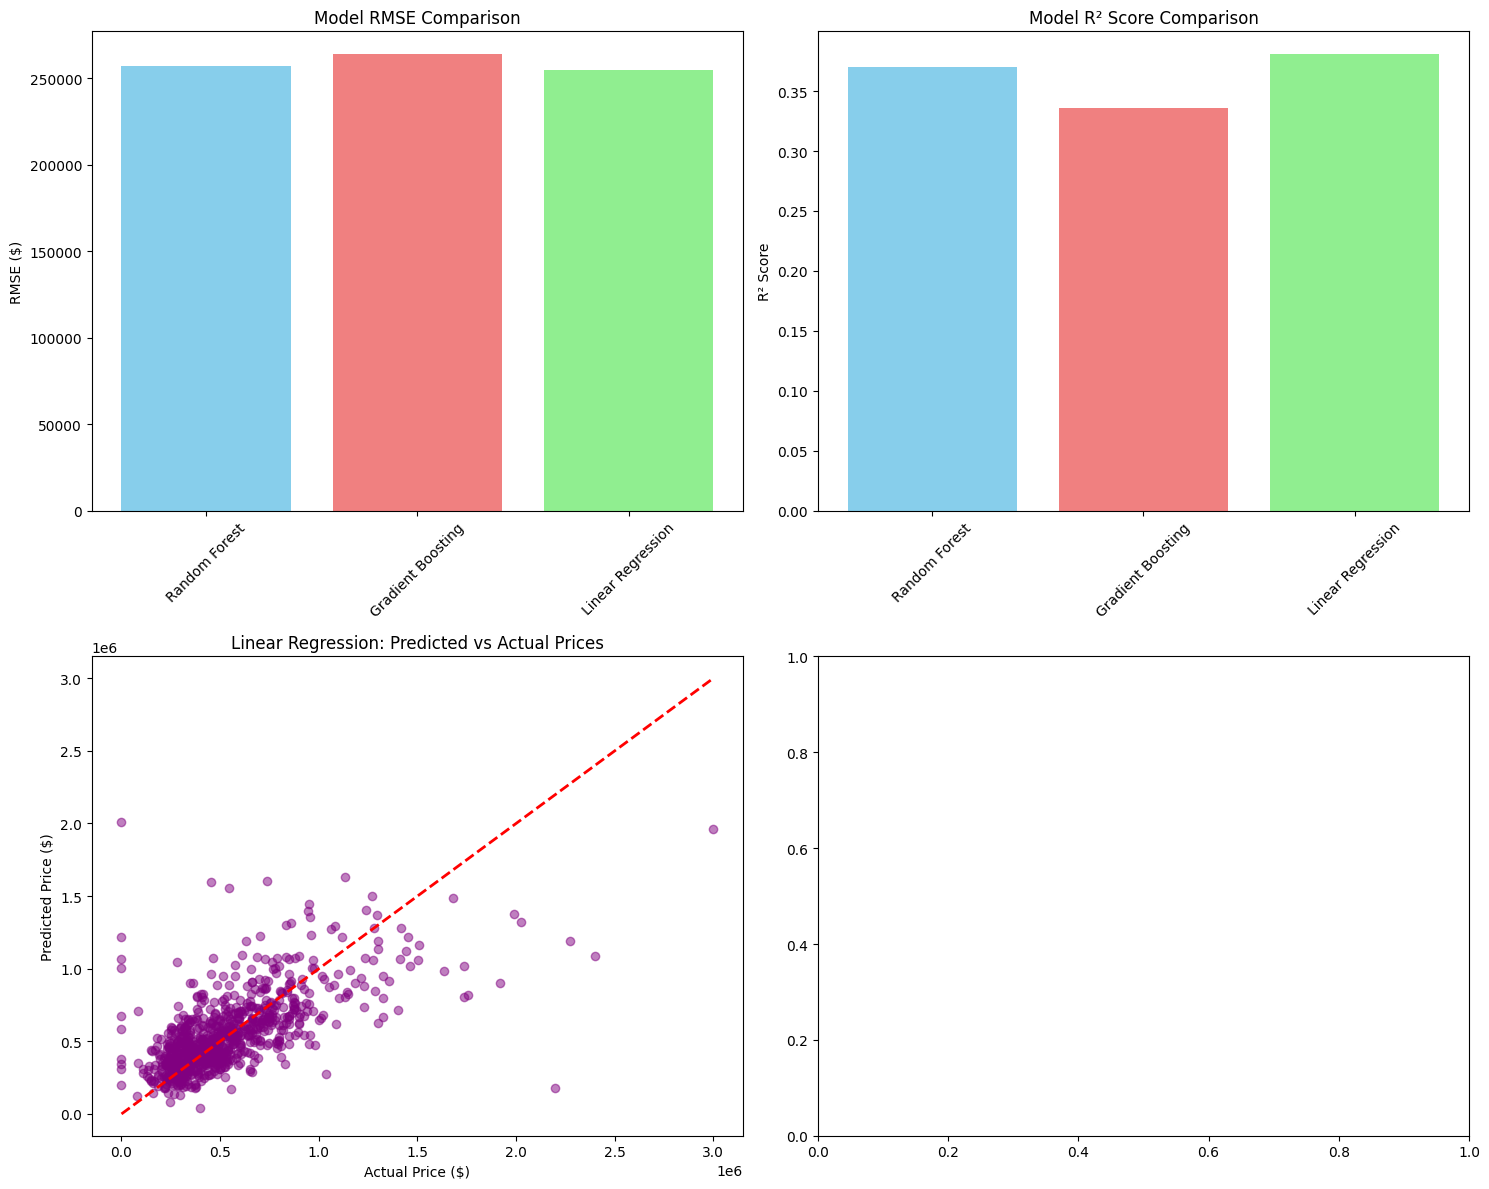

In [6]:
def visualize_model_performance(model_results, X_test, y_test):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    model_names = list(model_results.keys())
    rmse_scores = [model_results[name]["rmse"] for name in model_names]
    r2_scores = [model_results[name]["r2"] for name in model_names]
    
    axes[0,0].bar(model_names, rmse_scores, color=["skyblue", "lightcoral", "lightgreen"])
    axes[0,0].set_title("Model RMSE Comparison")
    axes[0,0].set_ylabel("RMSE ($)")
    axes[0,0].tick_params(axis="x", rotation=45)
    
    axes[0,1].bar(model_names, r2_scores, color=["skyblue", "lightcoral", "lightgreen"])
    axes[0,1].set_title("Model R² Score Comparison")
    axes[0,1].set_ylabel("R² Score")
    axes[0,1].tick_params(axis="x", rotation=45)
    
    best_name = min(model_results.keys(), key=lambda x: model_results[x]["rmse"])
    best_predictions = model_results[best_name]["predictions"]
    
    axes[1,0].scatter(y_test, best_predictions, alpha=0.5, color="purple")
    axes[1,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
    axes[1,0].set_title(f"{best_name}: Predicted vs Actual Prices")
    axes[1,0].set_xlabel("Actual Price ($)")
    axes[1,0].set_ylabel("Predicted Price ($)")
    
    if hasattr(model_results[best_name]["model"], "feature_importances_"):
        importances = model_results[best_name]["model"].feature_importances_
        feature_names = X_test.columns
        indices = np.argsort(importances)[::-1][:10]
        
        axes[1,1].barh(range(len(indices)), importances[indices], color="gold")
        axes[1,1].set_yticks(range(len(indices)))
        axes[1,1].set_yticklabels([feature_names[i] for i in indices])
        axes[1,1].set_title(f"{best_name}: Top 10 Feature Importances")
        axes[1,1].set_xlabel("Importance")
    
    plt.tight_layout()
    plt.show()

visualize_model_performance(model_results, X_test, y_test)

## 6. Property Valuation Function

In [7]:
def predict_property_value(property_features, model, scaler=None, model_name=""):
    
    feature_vector = np.array([
        property_features.get("bedrooms", 3),
        property_features.get("bathrooms", 2),
        property_features.get("sqft_living", 2000),
        property_features.get("sqft_lot", 8000),
        property_features.get("floors", 1),
        property_features.get("waterfront", 0),
        property_features.get("view", 0),
        property_features.get("condition", 3),
        property_features.get("sqft_above", property_features.get("sqft_living", 2000)),
        property_features.get("sqft_basement", 0),
        property_features.get("property_age", 20),
        property_features.get("years_since_renovation", property_features.get("property_age", 20)),
        property_features.get("sqft_living", 2000) + property_features.get("sqft_basement", 0),
        property_features.get("sqft_living", 2000) / property_features.get("sqft_lot", 8000),
        1 if property_features.get("sqft_basement", 0) > 0 else 0,
        1 if property_features.get("years_since_renovation", 100) < property_features.get("property_age", 20) else 0
    ]).reshape(1, -1)
    
    if len(feature_vector[0]) < len(X.columns):
        city_encoded = 50
        feature_vector = np.append(feature_vector, city_encoded).reshape(1, -1)
    
    if scaler and model_name == "Linear Regression":
        feature_vector = scaler.transform(feature_vector)
    
    predicted_price = model.predict(feature_vector)[0]
    
    return predicted_price

def ml_market_analysis(df, model, model_name):
    print(f"Average Property Price: ${df['price'].mean():,.0f}")
    print(f"Median Property Price: ${df['price'].median():,.0f}")
    print(f"Average Price per Sq Ft: ${df['price_per_sqft'].mean():.2f}")
    print(f"Average Square Footage: {df['sqft_living'].mean():,.0f}")
    print(f"\nML Model Used: {model_name}")
    print(f"Model Accuracy (R²): {model_results[model_name]['r2']:.3f}")
    
    clustering_features = df[["price", "sqft_living", "bedrooms", "bathrooms"]].fillna(df[["price", "sqft_living", "bedrooms", "bathrooms"]].median())
    kmeans = KMeans(n_clusters=4, random_state=42)
    df["market_segment"] = kmeans.fit_predict(clustering_features)
    
    segment_names = ["Budget", "Mid-Range", "Premium", "Luxury"]
    segment_stats = df.groupby("market_segment").agg({
        "price": ["mean", "median", "count"],
        "sqft_living": "mean",
        "bedrooms": "mean"
    }).round(0)
    
    print("\nMarket Segments Identified:")
    for i, name in enumerate(segment_names):
        count = segment_stats.loc[i, ("price", "count")]
        avg_price = segment_stats.loc[i, ("price", "mean")]
        avg_sqft = segment_stats.loc[i, ("sqft_living", "mean")]
        print(f"{name}: {count} properties, Avg Price: ${avg_price:,.0f}, Avg Sqft: {avg_sqft:,.0f}")
    
    return df

df = ml_market_analysis(df, best_model, best_model_name)

Average Property Price: $553,063
Median Property Price: $460,000
Average Price per Sq Ft: $265.84
Average Square Footage: 2,144

ML Model Used: Linear Regression
Model Accuracy (R²): 0.381

Market Segments Identified:
Budget: 1182 properties, Avg Price: $826,514, Avg Sqft: 2,814
Mid-Range: 1 properties, Avg Price: $26,590,000, Avg Sqft: 1,180
Premium: 2855 properties, Avg Price: $371,447, Avg Sqft: 1,786
Luxury: 102 properties, Avg Price: $2,212,438, Avg Sqft: 4,389


## 7. Investment Calculation Functions

In [8]:
def calculate_investment_risk(property_features, purchase_price, annual_cash_flow):
    risk_score = 0
    
    age = property_features.get("property_age", 20)
    if age > 50:
        risk_score += 2
    elif age > 30:
        risk_score += 1
    
    condition = property_features.get("condition", 3)
    if condition < 3:
        risk_score += 2
    elif condition < 4:
        risk_score += 1
    
    if annual_cash_flow < 0:
        risk_score += 3
    elif annual_cash_flow < 2400:
        risk_score += 1
    
    price_per_sqft = purchase_price / property_features.get("sqft_living", 2000)
    market_avg_psf = df["price_per_sqft"].median()
    if price_per_sqft > market_avg_psf * 1.2:
        risk_score += 1
    
    return min(risk_score, 10)

def ml_calculate_investment_metrics(property_features, down_payment_pct=20, 
                                  loan_rate=6.5, loan_term_years=30,
                                  monthly_rent=None, annual_appreciation=3.0,
                                  annual_expenses_pct=25, vacancy_rate=5,
                                  analysis_years=10, use_ml_prediction=True):
    
    if use_ml_prediction and "purchase_price" not in property_features:
        predicted_price = predict_property_value(property_features, best_model, scaler, best_model_name)
        purchase_price = predicted_price
        print(f"ML Predicted Property Value: ${purchase_price:,.0f}")
    else:
        purchase_price = property_features.get("purchase_price", 400000)
        print(f"Provided Property Value: ${purchase_price:,.0f}")
    
    down_payment = purchase_price * (down_payment_pct / 100)
    loan_amount = purchase_price - down_payment
    
    monthly_rate = loan_rate / 100 / 12
    num_payments = loan_term_years * 12
    monthly_mortgage = loan_amount * (monthly_rate * (1 + monthly_rate)**num_payments) / ((1 + monthly_rate)**num_payments - 1)
    
    if monthly_rent is None:
        sqft = property_features.get("sqft_living", 2000)
        bedrooms = property_features.get("bedrooms", 3)
        
        base_rent_per_sqft = df["price_per_sqft"].median() * 0.006
        bedroom_multiplier = 1 + (bedrooms - 2) * 0.1
        monthly_rent = sqft * base_rent_per_sqft * bedroom_multiplier
        
        print(f"ML Estimated Monthly Rent: ${monthly_rent:,.0f}")
    else:
        print(f"Provided Monthly Rent: ${monthly_rent:,.0f}")
    
    annual_rent = monthly_rent * 12
    annual_expenses = annual_rent * (annual_expenses_pct / 100)
    vacancy_loss = annual_rent * (vacancy_rate / 100)
    effective_annual_rent = annual_rent - vacancy_loss
    annual_mortgage_payments = monthly_mortgage * 12
    
    annual_cash_flow = effective_annual_rent - annual_expenses - annual_mortgage_payments
    monthly_cash_flow = annual_cash_flow / 12
    
    total_cash_invested = down_payment
    cash_on_cash_return = (annual_cash_flow / total_cash_invested) * 100
    cap_rate = ((effective_annual_rent - annual_expenses) / purchase_price) * 100
    gross_yield = (annual_rent / purchase_price) * 100
    
    risk_score = calculate_investment_risk(property_features, purchase_price, annual_cash_flow)
    
    print(f"\nPURCHASE DETAILS:")
    print(f"Purchase Price: ${purchase_price:,.0f}")
    print(f"Down Payment ({down_payment_pct}%): ${down_payment:,.0f}")
    print(f"Loan Amount: ${loan_amount:,.0f}")
    print(f"Monthly Mortgage: ${monthly_mortgage:,.0f}")
    
    print(f"\nRENTAL INCOME:")
    print(f"Monthly Rent: ${monthly_rent:,.0f}")
    print(f"Annual Rent: ${annual_rent:,.0f}")
    print(f"Vacancy Loss ({vacancy_rate}%): ${vacancy_loss:,.0f}")
    print(f"Effective Annual Rent: ${effective_annual_rent:,.0f}")
    
    print(f"\nEXPENSES:")
    print(f"Annual Expenses ({annual_expenses_pct}%): ${annual_expenses:,.0f}")
    print(f"Annual Mortgage Payments: ${annual_mortgage_payments:,.0f}")
    
    print(f"\nCASH FLOW:")
    print(f"Monthly Cash Flow: ${monthly_cash_flow:,.0f}")
    print(f"Annual Cash Flow: ${annual_cash_flow:,.0f}")
    
    print(f"\nINVESTMENT METRICS:")
    print(f"Cash-on-Cash Return: {cash_on_cash_return:.2f}%")
    print(f"Cap Rate: {cap_rate:.2f}%")
    print(f"Gross Yield: {gross_yield:.2f}%")
    print(f"ML Risk Score: {risk_score}/10 ({'Low' if risk_score < 3 else 'Medium' if risk_score < 6 else 'High'} Risk)")
    
    if cash_on_cash_return > 10 and cap_rate > 8 and risk_score < 3:
        recommendation = "EXCELLENT INVESTMENT"
    elif cash_on_cash_return > 6 and cap_rate > 6 and risk_score < 6:
        recommendation = "GOOD INVESTMENT"
    elif cash_on_cash_return > 3 and cap_rate > 4 and risk_score < 8:
        recommendation = "FAIR INVESTMENT"
    else:
        recommendation = "POOR INVESTMENT - CONSIDER ALTERNATIVES"
    
    print(f"\nML-ENHANCED RECOMMENDATION: {recommendation}")
    
    return {
        "purchase_price": purchase_price,
        "monthly_cash_flow": monthly_cash_flow,
        "annual_cash_flow": annual_cash_flow,
        "cash_on_cash_return": cash_on_cash_return,
        "cap_rate": cap_rate,
        "gross_yield": gross_yield,
        "risk_score": risk_score,
        "total_cash_invested": total_cash_invested,
        "recommendation": recommendation
    }

## 8. Example Investment Analysis

In [9]:
example_property = {
    "bedrooms": 3,
    "bathrooms": 2.5,
    "sqft_living": 2200,
    "sqft_lot": 8500,
    "floors": 2,
    "waterfront": 0,
    "view": 2,
    "condition": 4,
    "sqft_above": 2200,
    "sqft_basement": 0,
    "property_age": 15,
    "years_since_renovation": 15
}

ml_metrics = ml_calculate_investment_metrics(
    property_features=example_property,
    down_payment_pct=25,
    loan_rate=6.5,
    annual_appreciation=4.0,
    use_ml_prediction=True
)

manual_property = example_property.copy()
manual_property["purchase_price"] = 400000

manual_metrics = ml_calculate_investment_metrics(
    property_features=manual_property,
    down_payment_pct=25,
    loan_rate=6.5,
    annual_appreciation=4.0,
    use_ml_prediction=False
)

ML Predicted Property Value: $650,369
ML Estimated Monthly Rent: $3,537

PURCHASE DETAILS:
Purchase Price: $650,369
Down Payment (25%): $162,592
Loan Amount: $487,777
Monthly Mortgage: $3,083

RENTAL INCOME:
Monthly Rent: $3,537
Annual Rent: $42,439
Vacancy Loss (5%): $2,122
Effective Annual Rent: $40,317

EXPENSES:
Annual Expenses (25%): $10,610
Annual Mortgage Payments: $36,997

CASH FLOW:
Monthly Cash Flow: $-607
Annual Cash Flow: $-7,290

INVESTMENT METRICS:
Cash-on-Cash Return: -4.48%
Cap Rate: 4.57%
Gross Yield: 6.53%
ML Risk Score: 4/10 (Medium Risk)

ML-ENHANCED RECOMMENDATION: POOR INVESTMENT - CONSIDER ALTERNATIVES
Provided Property Value: $400,000
ML Estimated Monthly Rent: $3,537

PURCHASE DETAILS:
Purchase Price: $400,000
Down Payment (25%): $100,000
Loan Amount: $300,000
Monthly Mortgage: $1,896

RENTAL INCOME:
Monthly Rent: $3,537
Annual Rent: $42,439
Vacancy Loss (5%): $2,122
Effective Annual Rent: $40,317

EXPENSES:
Annual Expenses (25%): $10,610
Annual Mortgage Paymen

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## 9. Long-term Projections

Base Appreciation Rate: 4.0%
ML-Adjusted Appreciation Rate: 4.0%

Year 5 Property Value: $786,719
Year 5 Cumulative Cash Flow: $-38,694
Year 5 Total Return: $-64,937
Year 5 ROI: -39.9%

Year 10 Property Value: $942,527
Year 10 Cumulative Cash Flow: $-81,415
Year 10 Total Return: $48,151
Year 10 ROI: 29.6%


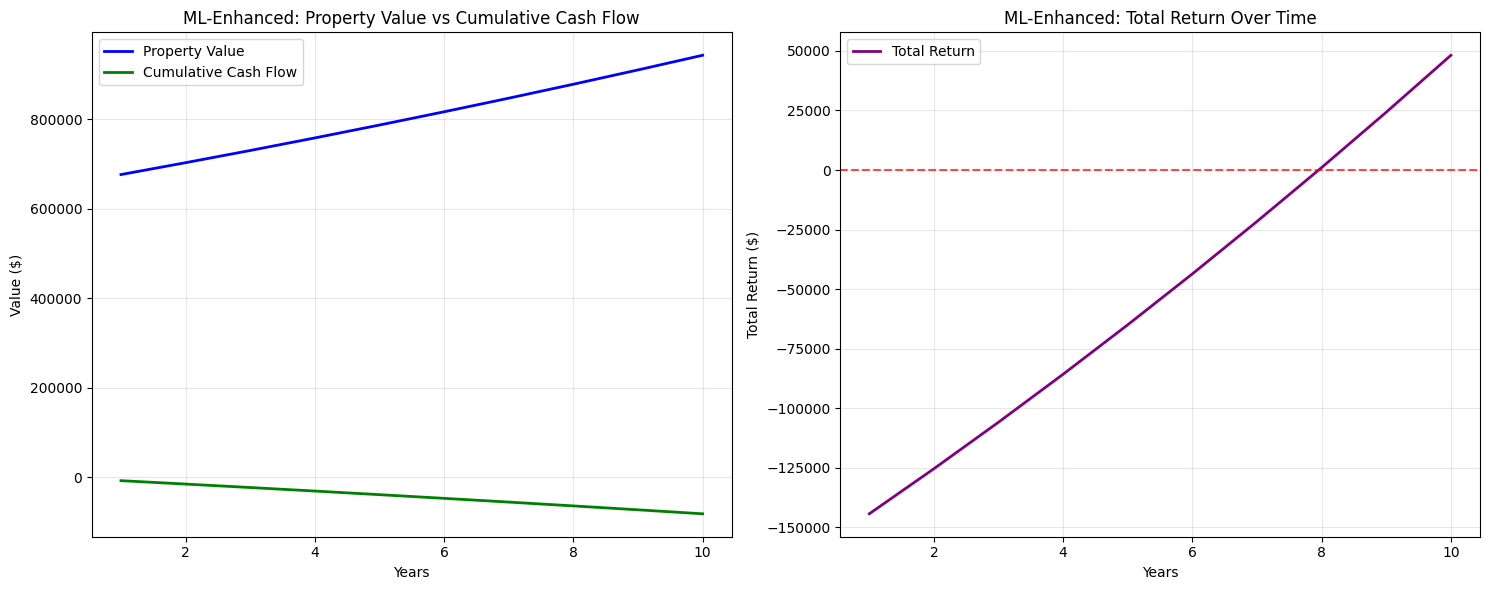

In [10]:

def ml_project_long_term_returns(purchase_price, annual_cash_flow, annual_appreciation, initial_investment, years, property_features):
    base_appreciation = annual_appreciation
    
    if property_features.get("waterfront", 0) == 1:
        base_appreciation += 0.5
    if property_features.get("view", 0) > 2:
        base_appreciation += 0.3
    
    age = property_features.get("property_age", 20)
    if age > 40:
        base_appreciation -= 0.3
    elif age > 25:
        base_appreciation -= 0.1
    
    print(f"Base Appreciation Rate: {annual_appreciation:.1f}%")
    print(f"ML-Adjusted Appreciation Rate: {base_appreciation:.1f}%")
    
    years_list = list(range(1, years + 1))
    property_values = []
    cumulative_cash_flow = []
    total_returns = []
    
    current_value = purchase_price
    cumulative_cf = 0
    
    for year in years_list:
        year_appreciation = base_appreciation * (1 - year * 0.01)
        current_value *= (1 + year_appreciation / 100)
        property_values.append(current_value)
        
        year_cash_flow = annual_cash_flow * (1 + 0.02) ** year
        cumulative_cf += year_cash_flow
        cumulative_cash_flow.append(cumulative_cf)
        
        total_return = cumulative_cf + (current_value - purchase_price) - initial_investment
        total_returns.append(total_return)
    
    print(f"\nYear 5 Property Value: ${property_values[4]:,.0f}")
    print(f"Year 5 Cumulative Cash Flow: ${cumulative_cash_flow[4]:,.0f}")
    print(f"Year 5 Total Return: ${total_returns[4]:,.0f}")
    print(f"Year 5 ROI: {(total_returns[4] / initial_investment) * 100:.1f}%")
    
    print(f"\nYear {years} Property Value: ${property_values[-1]:,.0f}")
    print(f"Year {years} Cumulative Cash Flow: ${cumulative_cash_flow[-1]:,.0f}")
    print(f"Year {years} Total Return: ${total_returns[-1]:,.0f}")
    print(f"Year {years} ROI: {(total_returns[-1] / initial_investment) * 100:.1f}%")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1.plot(years_list, property_values, label="Property Value", linewidth=2, color="blue")
    ax1.plot(years_list, cumulative_cash_flow, label="Cumulative Cash Flow", linewidth=2, color="green")
    ax1.set_title("ML-Enhanced: Property Value vs Cumulative Cash Flow")
    ax1.set_xlabel("Years")
    ax1.set_ylabel("Value ($)")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(years_list, total_returns, label="Total Return", linewidth=2, color="purple")
    ax2.axhline(y=0, color="red", linestyle="--", alpha=0.7)
    ax2.set_title("ML-Enhanced: Total Return Over Time")
    ax2.set_xlabel("Years")
    ax2.set_ylabel("Total Return ($)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        "property_values": property_values,
        "cumulative_cash_flow": cumulative_cash_flow,
        "total_returns": total_returns
    }

projections = ml_project_long_term_returns(
    purchase_price=ml_metrics["purchase_price"],
    annual_cash_flow=ml_metrics["annual_cash_flow"],
    annual_appreciation=4.0,
    initial_investment=ml_metrics["total_cash_invested"],
    years=10,
    property_features=example_property
)

## 10. Property Comparison Tool

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ML Predicted Property Value: $477,803
ML Estimated Monthly Rent: $2,894

PURCHASE DETAILS:
Purchase Price: $477,803
Down Payment (20%): $95,561
Loan Amount: $382,243
Monthly Mortgage: $2,416

RENTAL INCOME:
Monthly Rent: $2,894
Annual Rent: $34,723
Vacancy Loss (5%): $1,736
Effective Annual Rent: $32,987

EXPENSES:
Annual Expenses (25%): $8,681
Annual Mortgage Payments: $28,992

CASH FLOW:
Monthly Cash Flow: $-391
Annual Cash Flow: $-4,686

INVESTMENT METRICS:
Cash-on-Cash Return: -4.90%
Cap Rate: 5.09%
Gross Yield: 7.27%
ML Risk Score: 4/10 (Medium Risk)

ML-ENHANCED RECOMMENDATION: POOR INVESTMENT - CONSIDER ALTERNATIVES
ML Predicted Property Value: $1,244,440
ML Estimated Monthly Rent: $4,384

PURCHASE DETAILS:
Purchase Price: $1,244,440
Down Payment (20%): $248,888
Loan Amount: $995,552
Monthly Mortgage: $6,293

RENTAL INCOME:
Monthly Rent: $4,384
Annual Rent: $52,611
Vacancy Loss (5%): $2,631
Effective Annual Rent: $49,980

EXPENSES:
Annual Expenses (25%): $13,153
Annual Mortgage 

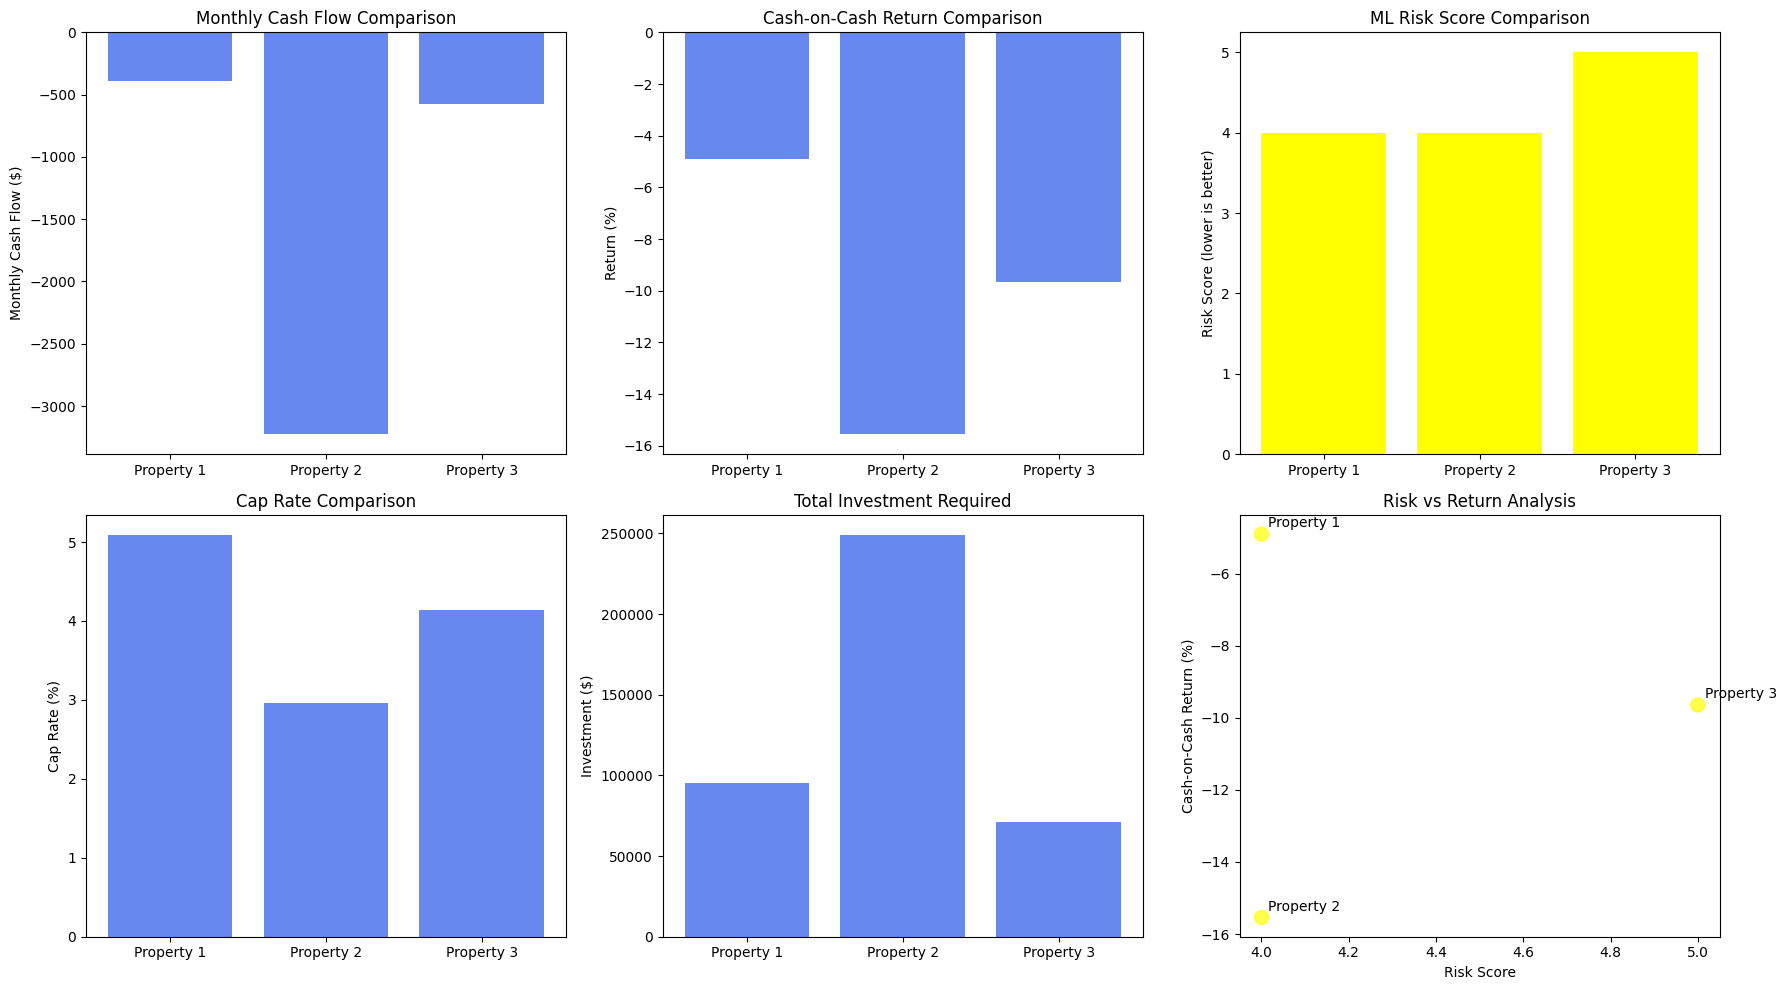

In [11]:

def ml_compare_properties(properties_list):
    comparison_data = []
    
    for i, prop in enumerate(properties_list):
        use_ml = "purchase_price" not in prop
        
        metrics = ml_calculate_investment_metrics(
            property_features=prop,
            down_payment_pct=prop.get("down_payment_pct", 20),
            loan_rate=prop.get("loan_rate", 6.5),
            monthly_rent=prop.get("monthly_rent"),
            annual_appreciation=prop.get("annual_appreciation", 3.5),
            use_ml_prediction=use_ml
        )
        
        comparison_data.append({
            "Property": f"Property {i+1}",
            "ML Predicted Price": metrics["purchase_price"] if use_ml else "Manual Input",
            "Monthly Cash Flow": metrics["monthly_cash_flow"],
            "Cash-on-Cash Return": metrics["cash_on_cash_return"],
            "Cap Rate": metrics["cap_rate"],
            "Risk Score": metrics["risk_score"],
            "Total Investment": metrics["total_cash_invested"]
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print(comparison_df.to_string(index=False, float_format="%.2f"))
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    axes[0,0].bar(comparison_df["Property"], comparison_df["Monthly Cash Flow"])
    axes[0,0].set_title("Monthly Cash Flow Comparison")
    axes[0,0].set_ylabel("Monthly Cash Flow ($)")
    
    axes[0,1].bar(comparison_df["Property"], comparison_df["Cash-on-Cash Return"])
    axes[0,1].set_title("Cash-on-Cash Return Comparison")
    axes[0,1].set_ylabel("Return (%)")
    
    risk_colors = ["green" if x < 3 else "yellow" if x < 6 else "red" for x in comparison_df["Risk Score"]]
    axes[0,2].bar(comparison_df["Property"], comparison_df["Risk Score"], color=risk_colors)
    axes[0,2].set_title("ML Risk Score Comparison")
    axes[0,2].set_ylabel("Risk Score (lower is better)")
    
    axes[1,0].bar(comparison_df["Property"], comparison_df["Cap Rate"])
    axes[1,0].set_title("Cap Rate Comparison")
    axes[1,0].set_ylabel("Cap Rate (%)")
    
    axes[1,1].bar(comparison_df["Property"], comparison_df["Total Investment"])
    axes[1,1].set_title("Total Investment Required")
    axes[1,1].set_ylabel("Investment ($)")
    
    axes[1,2].scatter(comparison_df["Risk Score"], comparison_df["Cash-on-Cash Return"], 
                     s=100, alpha=0.7, c=risk_colors)
    axes[1,2].set_title("Risk vs Return Analysis")
    axes[1,2].set_xlabel("Risk Score")
    axes[1,2].set_ylabel("Cash-on-Cash Return (%)")
    
    for i, prop in enumerate(comparison_df["Property"]):
        axes[1,2].annotate(prop, 
                          (comparison_df.iloc[i]["Risk Score"], 
                           comparison_df.iloc[i]["Cash-on-Cash Return"]),
                          xytext=(5, 5), textcoords="offset points")
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

properties_to_compare = [
    {
        "bedrooms": 3, "bathrooms": 2, "sqft_living": 1800, "sqft_lot": 7000,
        "floors": 1, "waterfront": 0, "view": 1, "condition": 3,
        "sqft_above": 1800, "sqft_basement": 0, "property_age": 25, "years_since_renovation": 25
    },
    {
        "bedrooms": 4, "bathrooms": 3, "sqft_living": 2500, "sqft_lot": 9000,
        "floors": 2, "waterfront": 1, "view": 4, "condition": 5,
        "sqft_above": 2500, "sqft_basement": 0, "property_age": 10, "years_since_renovation": 5
    },
    {
        "bedrooms": 2, "bathrooms": 1.5, "sqft_living": 1200, "sqft_lot": 5000,
        "floors": 1, "waterfront": 0, "view": 0, "condition": 4,
        "sqft_above": 1200, "sqft_basement": 0, "property_age": 35, "years_since_renovation": 35
    }
]

comparison_results = ml_compare_properties(properties_to_compare)

## 11. Custom Property Analysis (Customize This Section)

ML Predicted Property Value: $554,778
ML Estimated Monthly Rent: $3,215

PURCHASE DETAILS:
Purchase Price: $554,778
Down Payment (20%): $110,956
Loan Amount: $443,822
Monthly Mortgage: $2,805

RENTAL INCOME:
Monthly Rent: $3,215
Annual Rent: $38,581
Vacancy Loss (5%): $1,929
Effective Annual Rent: $36,652

EXPENSES:
Annual Expenses (25%): $9,645
Annual Mortgage Payments: $33,663

CASH FLOW:
Monthly Cash Flow: $-555
Annual Cash Flow: $-6,656

INVESTMENT METRICS:
Cash-on-Cash Return: -6.00%
Cap Rate: 4.87%
Gross Yield: 6.95%
ML Risk Score: 3/10 (Medium Risk)

ML-ENHANCED RECOMMENDATION: POOR INVESTMENT - CONSIDER ALTERNATIVES
Base Appreciation Rate: 3.5%
ML-Adjusted Appreciation Rate: 3.5%

Year 5 Property Value: $655,566
Year 5 Cumulative Cash Flow: $-35,333
Year 5 Total Return: $-45,500
Year 5 ROI: -41.0%

Year 10 Property Value: $768,131
Year 10 Cumulative Cash Flow: $-74,343
Year 10 Total Return: $28,055
Year 10 ROI: 25.3%


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


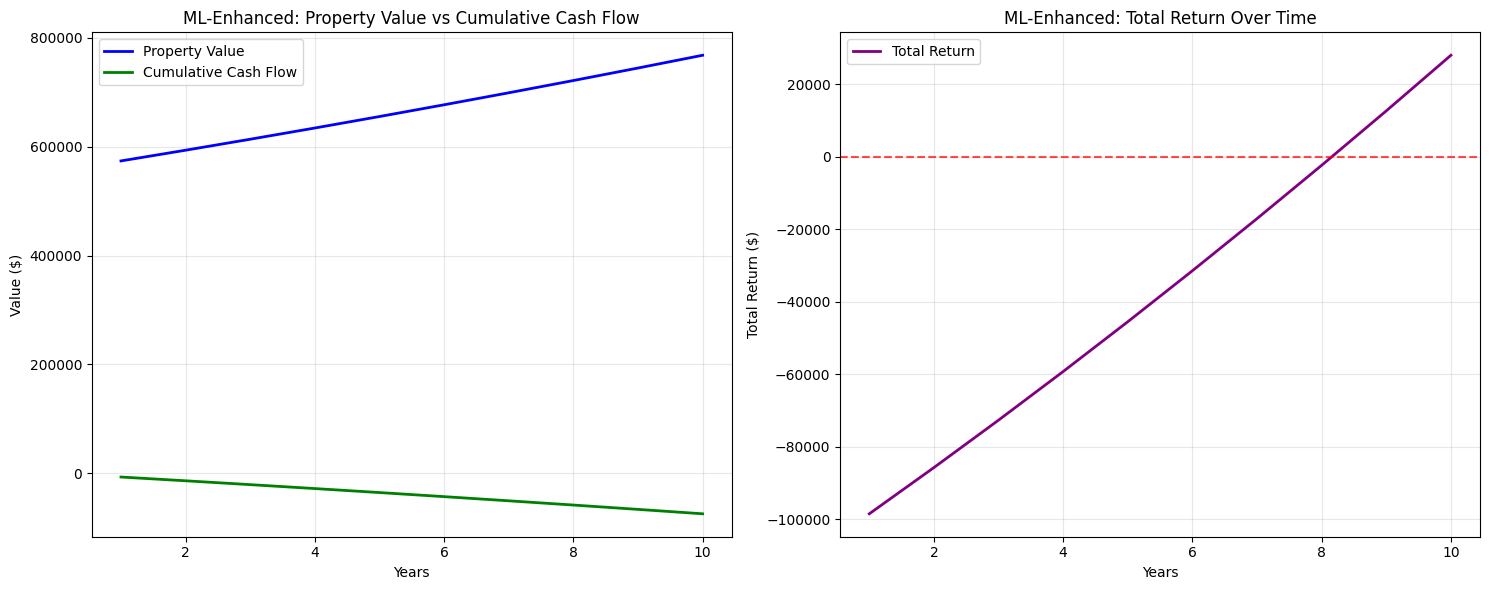

{'property_values': [np.float64(574000.5647618391),
  np.float64(593688.7841331701),
  np.float64(613844.5183544912),
  np.float64(634469.6941712021),
  np.float64(655565.8115023946),
  np.float64(677133.9267008234),
  np.float64(699174.6360149352),
  np.float64(721688.0592946161),
  np.float64(744673.8239831496),
  np.float64(768131.0494386188)],
 'cumulative_cash_flow': [np.float64(-6789.44804026895),
  np.float64(-13714.685041343277),
  np.float64(-20778.42678243909),
  np.float64(-27983.443358356824),
  np.float64(-35332.56026579291),
  np.float64(-42828.65951137772),
  np.float64(-50474.680741874225),
  np.float64(-58273.62239698066),
  np.float64(-66228.54288518922),
  np.float64(-74342.56178316196)],
 'total_returns': [np.float64(-98521.9115625906),
  np.float64(-85758.92919233389),
  np.float64(-72666.93671210864),
  np.float64(-59246.77747131544),
  np.float64(-45499.77704755905),
  np.float64(-31427.76109471511),
  np.float64(-17033.07301109977),
  np.float64(-2318.5913865253

In [12]:
your_property_features = {
    "bedrooms": 3,
    "bathrooms": 2.5,
    "sqft_living": 2000,
    "sqft_lot": 8000,
    "floors": 2,
    "waterfront": 0,
    "view": 1,
    "condition": 4,
    "sqft_above": 2000,
    "sqft_basement": 0,
    "property_age": 15,
    "years_since_renovation": 15,
    
    "down_payment_pct": 20,
    "loan_rate": 6.5,
    "monthly_rent": None,
    "annual_appreciation": 3.5,
    "annual_expenses_pct": 25,
    "vacancy_rate": 5,
    "analysis_years": 10
    
}

your_ml_metrics = ml_calculate_investment_metrics(
    property_features=your_property_features,
    down_payment_pct=your_property_features["down_payment_pct"],
    loan_rate=your_property_features["loan_rate"],
    monthly_rent=your_property_features["monthly_rent"],
    annual_appreciation=your_property_features["annual_appreciation"],
    annual_expenses_pct=your_property_features["annual_expenses_pct"],
    vacancy_rate=your_property_features["vacancy_rate"],
    analysis_years=your_property_features["analysis_years"],
    use_ml_prediction="purchase_price" not in your_property_features
)

ml_project_long_term_returns(
    purchase_price=your_ml_metrics["purchase_price"],
    annual_cash_flow=your_ml_metrics["annual_cash_flow"],
    annual_appreciation=your_property_features["annual_appreciation"],
    initial_investment=your_ml_metrics["total_cash_invested"],
    years=your_property_features["analysis_years"],
    property_features=your_property_features
)